In [1]:
import random

def read_cnf_file(fname):
    import sys
    """this function basically reads the cnf file given as unput and sets up the equation F"""
    print ("reading the file: {}".format(fname))
    fhand= open(fname,"r")
    expression=[]
    variable_occurance=[]
    for line in fhand:
        line=line.strip()
        words=line.split()
        if(words[0]=="c"):
            #print("this is a comment line")
            continue
        if(words[0]=="p"):
            #print("it is a configuration line meaning (variables,clauses)")
            total_variables=int(words[2])
            total_clauses=int(words[3])
            continue
        if(words[0]=="%"):
            #print("this basically means the end of the file")
            #so break the operation of reading the lines
            break
        if (total_variables == -1 or total_clauses == -1): #if the configuration line is bad # basically a sanity check
            print ("Error, unexpected data")
            sys.exit(0) #close the file
            
        #######by here we introduced what are all the things we need to do if the file is in bad shape or
        ####with comments
        #####hopefully we should get a value of total clauses and total variables by now
        ###coming over to what we want to do with the file now because it's now only the data that is left
        clause=[]
        for char in words: #finally we are down with numbers 
            literal = int(char) #convert these numbers into values
            if (literal == 0): #check if the literal count is 0 #clause update takes place after there is a zero in the line
                expression.append(clause) #update the clause in the expression
                clause = [] # reset the clause
                continue
            var = abs(literal) # if variable is a number other than zero meaning it's not a termination statement
            if (var not in variable_occurance):
                variable_occurance.append(var)
            clause.append(literal)#also add the same variable in the current clause
    ######final check if the total number of variables or clauses in the expression generated do not match with the
    #####first configartion line that started with the "p" then there was something wrong with the extraction process 
    ## or a wrong file with "p" arguements was given
    #so let's check that 
    
    if((len(variable_occurance)==total_variables) & (len(expression)==total_clauses)):
        print("read file successful")
    else:
        print("mismatch with the line 'p' and the total number of variables received")
        #print(variable_occurance)
        #print(expression)
        print("variables given in 'p' file :{} and actually found : {}".format(total_variables,len(variable_occurance)))
        print("clauses given in the 'p' file : {} and actually found :{}".format(total_clauses,len(expression)))
        
    return[variable_occurance,expression]

def random_assignment(variables):
    """returns a dictionary of variables with randomly generated values"""
    ls=list(range(1,variables+1))
    look_up_table={}
    for elements in ls:
        import random
        num=random.randint(0,1)
        look_up_table[elements]=num
    return look_up_table

def flip(x):
    if(x==1):
        res=0
    elif(x==0):
        res=1
    else:
        print("flip not 0 or 1 input given")
    return res

def compute_clause(clause,look_ups):
    """this function takes the mapping table"""
    status=False
    for element in clause:
        #print("element",element)
        #print("lookups",look_ups)
        val=look_ups[abs(element)]
        if(element<0):
            val=flip(val)
        if(val==1):
            val=True
        else:
            val=False
        status=status or val
    if(status==True):
        #print("we got atleast 1 variable right")
        return True
    else:
        return False
        
def unsat_flips(look_ups,unsat_clauses):
    """flips a/multiple random literal in unsat_clauses """
    #print(unsat_clauses)
    unique_literal_in_unsat=[]
    for clause in unsat_clauses:
        for literal in clause:
            if(literal not in unique_literal_in_unsat):
                unique_literal_in_unsat.append(literal)
    #print("this is unique literal list",unique_literal_in_unsat)
    num=random.randint(0,len(unique_literal_in_unsat)-1)
    choosen_literal=unique_literal_in_unsat[num]
    if(choosen_literal<0):
            choosen_literal=-choosen_literal
    old_val=look_ups[choosen_literal]
    new_val=flip(old_val)
    look_ups[choosen_literal]=new_val
    

def sat_checker(clauses,look_ups):
    """this function basically checks the expression of clauses by fitting the look_ups from the table"""
    """returns true if the solution is valid or else False"""
    unsat_count=0
    unsat_clauses_list=[]
    for clause in clauses:
        if(compute_clause(clause,look_ups)==False):
                unsat_count+=1
                unsat_clauses_list.append(clause)
    if(unsat_count==0):
        #print("we have found a solution for this sat problem")
        return True
    return False



def gwsat_solver(iterations,file,walk_prob):
    """only flips a literal in the list of unsat clauses"""
    from tqdm import tqdm
    read=read_cnf_file(file)
    unique_elements=len(read[0])
    clauses=read[1]
    #start with a random assignment
    look_ups=random_assignment(unique_elements)
    if(sat_checker(clauses,look_ups)==True):
        print("random solution solves the problem")
        return [True , look_ups]
    iter_count=0
    for i in tqdm(range(iterations)):
        #return a list of unsat clauses
        unsat_data=return_unsat_clauses(clauses,look_ups)
        unsat_clauses_list=unsat_data[2]
        unsat_count=unsat_data[1]
        status=unsat_data[0]
        if(status==False):
            print("this means that there were no unsat clauses in the solution generated by the current lookup")
        r=random.uniform(0,1)
        if(r<walk_prob):
            #we need to choose a variable at random
            #print("we are in r",r)
            #this basically flips one clause in the set of unsat clauses
            unsat_flips(look_ups,unsat_clauses_list)
        else:
            #print("we are in not r")
            #flip a variable with min gain or breaking the ties
            gains_list=calc_gains(unsat_clauses_list,look_ups,clauses) # a function that returns the gains of changing each literalin unsat clause
            #print(gains_list)
            highest=max(gains_list.items(), key=lambda x: x[1])
            #print("highest",highest)
            highest_gain=highest[1]
            shuffling_list=[]
            for literal,gain_value in gains_list.items():
                if(gain_value==highest_gain):
                    shuffling_list.append(literal)
            num=random.randint(0,len(shuffling_list)-1)
            highest_gain_literal=shuffling_list[num]
            #print("this is the shuffling list",shuffling_list)
            #print("selected highest",highest_gain_literal)
            #flip this value that gives me the highest gain
            old_val=look_ups[highest_gain_literal]
            new_val=flip(old_val)
            look_ups[highest_gain_literal]=new_val
        if(sat_checker(clauses,look_ups)==True):
            iter_count=i
            print("we found the solution after repeatedly flipping the net gain value :",i)
            break
            
    ####check whatever after the for loop is given or not 
    if(sat_checker(clauses,look_ups)==True):
            print("we solved the problem and found a solution")
            return [True ,look_ups,iter_count]
    else:
        print("we ran out of the total number of iterations, no solution found")
        return [False,look_ups,iter_count]
    
def return_unsat_clauses(clauses,look_ups):
    """returns a list of unsat clauses"""
    unsat_count=0
    unsat_clauses_list=[]
    for clause in clauses:
        if(compute_clause(clause,look_ups)==False):
                unsat_count+=1
                unsat_clauses_list.append(clause)
    if(unsat_count==0):
        #print("we have found a solution for this sat problem")
        return [False,unsat_count,unsat_clauses_list]
    return [True,unsat_count,unsat_clauses_list]

def return_sat_clauses(clauses,look_ups):
    """returns a list of sat clauses"""
    sat_count=0
    sat_clauses_list=[]
    for clause in clauses:
        if(compute_clause(clause,look_ups)==True):
                sat_count+=1
                sat_clauses_list.append(clause)
    if(sat_count==0):
        #print("we have found a solution for this sat problem")
        return [False,sat_count,sat_clauses_list]
    return [True,sat_count,sat_clauses_list]
 
def calc_gains(unsat_clauses,look_ups,clauses):
    """this function returns the gain value of each clause"""
    current_sat=[] #before flip contains sat clauses
    for clause in clauses:
        if(clause not in unsat_clauses):
            #then it's a sat clause currently
            current_sat.append(clause)
    gains={}
    for clause in clauses:
        for literal in clause:
            if(literal<0):
                literal=-literal
            if(literal in gains):
                continue
            else:
                gain=check_impact(literal,look_ups,current_sat,clauses,unsat_clauses)
                #the more negative the gain is the more are the number of sat clauses that became unsat after fliipping the literal
                #in other words the bigger negative this number is the bad is the decision of flipping
                gains[literal]=gain
    return gains
                
def check_impact(literal,look_ups,current_sat,clauses,unsat_clauses):
    """checks the impact of flipping that variable by calculating the gain"""
    old_val=look_ups[literal]
    new_val=flip(old_val)
    look_ups[literal]= new_val
    #unsat_clauses=> current unsat clauses
    points=0
    #print("point at zero",points)
    unsat_data=return_unsat_clauses(clauses,look_ups)
    after_unsat_list=unsat_data[2]
    for clause in current_sat: #check for current sat clauses 
        if (clause in after_unsat_list):#that became unsat
            points-=1
    #print("points after negative gain",points)
    #unsat clauses=>
    sat_data=return_sat_clauses(clauses,look_ups)
    after_sat_list=sat_data[2]
    for clause in unsat_clauses: #check for current unsat that become sat
        if (clause in after_sat_list):#that became unsat
            points+=1
    #print("points after positive gain",points)
    #put everything back to the original
    old_val=look_ups[literal]
    new_val=flip(old_val)
    look_ups[literal]= new_val
    return points
        

In [2]:
import argparse
parser = argparse.ArgumentParser(
                    description='Match files for certain matches & run program on matches') #initialize with
parser.add_argument('-file', '--file', type=str ,default="uf20-01.cnf",
                    help='the cnf file you wish to open ?')
parser.add_argument('-iter', '--iter', type=int ,default=1000,
                    help='total number of iterations you want to run this code for ?')
parser.add_argument('-w_p', '--walk_prob', type=float ,default=0.4,
                    help='defines the walking_prob')
parser.add_argument('-execs', '--execs', type=int ,default=100,
                    help='defines the total number of executions you want to try')
parser.add_argument('-restarts', '--restarts', type=int ,default=10,
                    help='defines the number of restarts allowed if the set answer is not found in iterations')
args =parser.parse_args()
#print(args.file,args.iter,args.walk_prob)
file=args.file
iterations=args.iter
walk_prob=args.walk_prob
executions=args.execs
restarts=args.restarts
###############################
file="uf20-02.cnf"
iterations=1000
walk_prob=0.4
executions=100
restarts=10
###############################
sol_count=0
no_sol_count=0

soln=[]
results_of_runs=[]

for i in range(executions):
    random.seed(183262 + i*2605)
    import time
    tic=time.time()
    for j in range(restarts):
        look_ups=gwsat_solver(iterations,file,walk_prob)
        print(look_ups)
        print("================we are now in the testing phase================")
        read=read_cnf_file(file)
        clauses=read[1]
        if(look_ups[0]==False):
            print("we were out of iterations....")
        if(sat_checker(clauses,look_ups[1])==True):
            toc=time.time()
            time_diff=toc-tic
            result=[i,j,look_ups,time_diff]
            results_of_runs.append(result)
            print("solution is verified")
            sol_count+=1
            soln.append(look_ups[1])
            break
        else:
            print("solution is not verified")
            continue
            


  0%|          | 0/1000 [00:00<?, ?it/s]

reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 46
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 46]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 141
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 141]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 251
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 251]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 239
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 239]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful


  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 132
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0}, 132]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 22
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 22]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 93
we solved the problem and found a 

 16%|█▌        | 155/1000 [00:00<00:00, 1527.57it/s]

we found the solution after repeatedly flipping the net gain value : 151
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 151]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful


  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 386
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 386]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 100
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 100]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 185
we solved the problem and found

 14%|█▍        | 144/1000 [00:00<00:00, 1344.80it/s]

 56
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 56]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 65
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 65]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 48
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1,


  0%|          | 0/1000 [00:00<?, ?it/s]

we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 162]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 95
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 95]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 137
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 1

 13%|█▎        | 133/1000 [00:00<00:00, 1329.73it/s]

we found the solution after repeatedly flipping the net gain value : 507
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 507]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 118
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 118]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful


 15%|█▌        | 154/1000 [00:00<00:00, 1536.31it/s]

we found the solution after repeatedly flipping the net gain value : 417
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 417]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 23
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 23]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 91
we solved the problem and found a 

  0%|          | 0/1000 [00:00<?, ?it/s]


we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 243]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 89
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 89]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 91
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 109
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 109]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 33
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 33]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 65
we solved the problem and found a 

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 475
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 475]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 249
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 249]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful


  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 109
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0}, 109]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 14
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 14]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 209
we solved the problem and found a

 13%|█▎        | 128/1000 [00:00<00:00, 1262.69it/s]

we found the solution after repeatedly flipping the net gain value : 162
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 162]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 71
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 71]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 28
we solved the problem and found a 

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 181
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0}, 181]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 74
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0}, 74]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 107
we solved the problem and found a

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 416
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 416]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 92
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 92]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 111
we solved the problem and found a

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 111
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0}, 111]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 156
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 156]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful


  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 139
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 139]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 181
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0}, 181]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 28
we solved the problem and found 

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 154
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 154]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 193
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 193]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful


 17%|█▋        | 173/1000 [00:00<00:00, 1699.96it/s]

we found the solution after repeatedly flipping the net gain value : 236
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 236]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 83
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 83]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 109
we solved the problem and found a

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 474
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 474]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 130
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 130]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 85
we solved the problem and found 

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 155
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 155]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 145
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 145]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 46
we solved the problem and found 

 15%|█▍        | 147/1000 [00:00<00:00, 1194.53it/s]

we found the solution after repeatedly flipping the net gain value : 254
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 254]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 141
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 141]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 14
we solved the problem and found 


  0%|          | 0/1000 [00:00<?, ?it/s]

we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 181]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 186
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 186]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 84
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 151
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 151]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 22
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 22]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 20
we solved the problem and found a 

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 305
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 305]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 21
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 21]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 51
we solved the problem and found a 

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 323
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 323]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 33
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 33]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 79
we solved the problem and found a 

  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 222
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 222]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 259
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 259]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 17
we solved the problem and found 


  0%|          | 0/1000 [00:00<?, ?it/s]

read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 57
we solved the problem and found a solution
[True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 57]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful
we found the solution after repeatedly flipping the net gain value : 177
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 177]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified
reading the file: uf20-02.cnf
read file successful


  0%|          | 0/1000 [00:00<?, ?it/s]

we found the solution after repeatedly flipping the net gain value : 65
we solved the problem and found a solution
[True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0}, 65]
================we are now in the testing phase================
reading the file: uf20-02.cnf
read file successful
solution is verified


In [3]:
print("******this is the final verdict******")            
print("this is the length of soln list:",len(soln))
unique_soln=[]
for item in soln:
    if(item not in unique_soln):
        unique_soln.append(item)
print("this is the length of unique soln list:",len(unique_soln))
print("executions with successful solutions:",sol_count)

******this is the final verdict******
this is the length of soln list: 100
this is the length of unique soln list: 27
executions with successful solutions: 100


In [4]:
print(results_of_runs)

[[0, 0, [True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 46], 0.020634174346923828], [1, 0, [True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 141], 0.0833280086517334], [2, 0, [True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 119], 0.05416989326477051], [3, 0, [True, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 251], 0.12184691429138184], [4, 0, [True, {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 0, 19: 1, 20: 0}, 239], 0.164093017578125], [5, 0, [True, {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18

In [5]:
def write_out(filename,results_of_runs):
    """writes the files in folder called results"""
    import os
    path = os.getcwd()
    path=path+"/results"#<<<<<<<remove "/TSP dataset" if file is in the same level of directory
    try:
        os.chdir(path)
    except:
        os.mkdir(path)
        os.chdir(path)
    #write file in this directory
    for i in results_of_runs:
        first_line="c "+"execution: "+str(i[0])
        second_line="c "+"restarts: "+str(i[1])
        third_line="c "+"out_of_iteration status: "+str(i[2][0])
        fourth_line="c "+"iteration no: "+str(i[2][2])
        fifth_line="c "+"time taken: "+str(i[3])
        solution=i[2][1]
        file = open(filename[:-4]+"_GWsat_"+str(i[0])+".cnf", "w")
        file.write(first_line) 
        file.write("\n")
        file.write(second_line) 
        file.write("\n")
        file.write(third_line) 
        file.write("\n")
        file.write(fourth_line) 
        file.write("\n")
        file.write(fifth_line) 
        file.write("\n")
        appension=[]
        for k,v in solution.items():
            if(v==1):
                temp=str(k)
            else:
                temp=str(-k)
            appension.append(temp)
        count=0
        line="v "
        for element in appension:
            line+=element+" "
            count+=1
            if(count==5):
                file.write(line) 
                file.write("\n")
                line="v "
                count=0
                continue
        if(count>0):
            file.write(line) 
            file.write("\n")
        termination="v 0"
        file.write(termination)
        file.close()
        #print("file write successful")
    #move back one lev in directories
    os.chdir('..')#move back one lev now
    
def make_plots(file,executions,results_of_runs):
    """makes a time vs execution plot for the variables"""
    #plotting graphs with matplot lib
    executions=list(range(executions))
    time=[]
    for elements in results_of_runs:
        temp=elements[3]
        time.append(temp)
    %matplotlib inline
    #print(time)
    import warnings
    warnings.filterwarnings("ignore")
    import matplotlib.pyplot as plt
    plt.figure(1, figsize=(6, 4))
    plt.clf()
    plt.plot(executions, time, linewidth=2,label="execution time")
    #plt.plot(executions, time, 'ro')
    plt.axis('tight')
    plt.grid()
    plt.xlabel('executions')
    plt.ylabel('time of execution')
    plt.title("CPU execution time for solving sat problem")
    plt.legend()
    plt.show()
    ind=time.index(max(time))
    print("maximum time is {} sec at {}th run".format(max(time),ind))
    ############normal plot with sorted values
    time1=sorted(time)
    import statistics
    mean_val=statistics.mean(time1)
    y=[]
    for i in range(100):
        y.append(mean_val)
    mean_val=y
    plt.figure(1, figsize=(6, 4))
    plt.clf()
    plt.plot(executions, time1, linewidth=2, label="average execution, no order wise")
    plt.plot(executions, mean_val, linewidth=2,label="mean on the line")
    plt.axis('tight')
    plt.grid()
    plt.xlabel('execution not in specefic order')
    plt.ylabel('time of execution')
    plt.title("CPU execution time for solving sat problem")
    plt.legend()
    plt.show()
    print("average time is {} sec".format(mean_val[0]))
    ####################################### semi log plots
    plt.semilogx(time1, executions)
    plt.xlabel("executions")
    plt.ylabel("time taken per execution")
    plt.title("semi log graph")
    plt.axis('tight')
    plt.grid()
    plt.show()
    ############################
    import pandas as pd
    import seaborn as sns
    iterations=[]
    solns=[]
    statuses=[]
    restarts=[]
    for element in results_of_runs:
        iter_count=element[2][2]
        status=element[2][0]
        soln=element[2][1]
        restart=element[1]
        iterations.append(iter_count)
        solns.append(soln)
        statuses.append(status)
        restarts.append(restart)
    df = pd.DataFrame(list(zip(time, executions,iterations,solns,statuses,restarts)), 
               columns =['time', 'execs',"iterations","solution","status","restarts"])
    display(df.describe())
    df.to_csv(file+".csv")
    #x = pd.Series(df["time"], name="time/execution")
    #ax = sns.distplot(df["time"])
                      
    x = pd.Series(df["iterations"], name="average iters")
    ax = sns.distplot(df["iterations"])

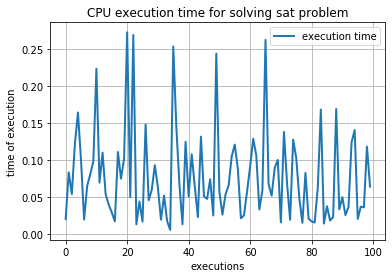

maximum time is 0.2722029685974121 sec at 20th run


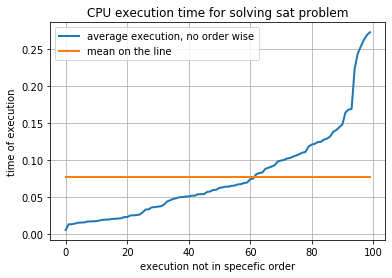

average time is 0.07697598457336426 sec


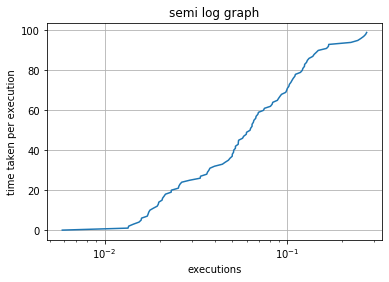

,time,execs,iterations,restarts
count,100.000000,100.000000,100.000000,100.0
mean,0.076976,49.500000,127.470000,0.0
std,0.060960,29.011492,108.606923,0.0
min,0.005869,0.000000,12.000000,0.0
25%,0.028581,24.750000,47.500000,0.0
50%,0.061235,49.500000,99.500000,0.0
75%,0.105117,74.250000,162.000000,0.0
max,0.272203,99.000000,507.000000,0.0


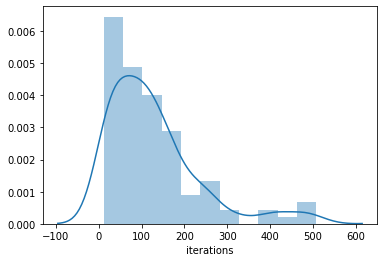

In [6]:
plot=True
if(plot==True):
    make_plots(file,executions,results_of_runs)

In [7]:
write_solution=True
plot=True

In [8]:
if(write_solution==True):
    write_out(file,results_of_runs)